In [1]:
%%time

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import normalize

plt.rcParams['figure.figsize'] = 5.0, 4.0

from pyts.transformation import GADF,GASF
from sklearn.preprocessing import normalize

import uproot
import torch
from torch.utils.data import DataLoader
from torch.autograd import Variable

from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster

from heatmapcluster import heatmapcluster

CPU times: user 1.17 s, sys: 360 ms, total: 1.53 s
Wall time: 2.64 s


In [ ]:
tree = uproot.open("Run9goodDataQ_dualgate")["tree"]
energy = tree.array("Energy")
print(tree)
del tree
energy = energy[:,1]

label = np.load("label.npy")
label2 = np.load("label_4.npy")
survives = np.load("survives.npy")
final = np.load("final.npy")
final_final = np.load("final_final.npy")
really_final = np.load("really_final.npy")

energy1 = energy[label==4]
energy2 = energy1[label2==1]
energy3 = energy2[survives==0]
energy4 = energy3[final==1]
energy5 = energy4[final_final==1]
energy6 = energy5[really_final==1]

In [ ]:
plt.hist(energy,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy1,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy2,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy3,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy4,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy5,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
plt.hist(energy6,bins=np.arange(3000,8000,5))
plt.yscale("log")
plt.show()

In [ ]:
print(len(dataset))
n_batches = int(len(dataset)/BATCH_SIZE) 

In [2]:
from torch import nn
from torch.autograd import Variable
import torch.nn.functional as F

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()        
#         self.norm = nn.BatchNorm1d(1)
        self.cv1 = nn.Conv1d(1, 64, kernel_size=4, stride=2, padding=4)
        self.pl1 = nn.MaxPool1d(2, stride=2)
        self.cv2 = nn.Conv1d(64, 32, kernel_size=4, stride=2, padding=4)
        self.pl2 = nn.MaxPool1d(2, stride=2)
        self.cv31 = nn.Conv1d(32, 8, kernel_size=4, stride=2, padding=4)
        self.pl31 = nn.MaxPool1d(2, stride=2)
        self.cv32 = nn.Conv1d(32, 8, kernel_size=4, stride=2, padding=4)
        self.pl32 = nn.MaxPool1d(2, stride=2)
                
        self.ct1 = nn.ConvTranspose1d(8, 32, kernel_size=4, stride=4, padding=2)
        self.up1 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct2 = nn.ConvTranspose1d(32, 32, kernel_size=4, stride=2, padding=1)
        self.up2 = nn.Upsample(scale_factor=2, mode='nearest')
        self.ct3 = nn.ConvTranspose1d(32, 1, kernel_size=4, stride=2, padding=1)

    def encoder(self, x):
#         h0 = self.norm(x)
        h1 = F.tanh(self.pl1(self.cv1(x)))
        h2 = F.tanh(self.pl2(self.cv2(h1)))
        return self.pl31(self.cv31(h2)), self.pl32(self.cv32(h2))
    
    def reparameterise(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eps = torch.FloatTensor(std.size()).normal_()
        eps = Variable(eps)
        return eps.mul(std).add_(mu)
    
    def decoder(self, z):
        h3 = F.leaky_relu(self.ct1(z))
        h3 = self.up1(h3)
        h3 = F.leaky_relu(self.ct2(h3))
        h3 = self.up2(h3)
        return F.leaky_relu(self.ct3(h3))
    
    def forward(self,inputs):
        mu, logvar = self.encoder(inputs)
        z = self.reparameterise(mu, logvar)
        return self.decoder(z), mu, logvar
print("Autoencoder")

GEN = Autoencoder()
print(GEN)

criterion = nn.L1Loss()
optimizer = torch.optim.Adam(GEN.parameters(), lr=0.001, weight_decay=1e-5)

for parameter in GEN.parameters():
    print(parameter.size())

Autoencoder
Autoencoder(
  (cv1): Conv1d(1, 64, kernel_size=(4,), stride=(2,), padding=(4,))
  (pl1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv2): Conv1d(64, 32, kernel_size=(4,), stride=(2,), padding=(4,))
  (pl2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv31): Conv1d(32, 8, kernel_size=(4,), stride=(2,), padding=(4,))
  (pl31): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cv32): Conv1d(32, 8, kernel_size=(4,), stride=(2,), padding=(4,))
  (pl32): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (ct1): ConvTranspose1d(8, 32, kernel_size=(4,), stride=(4,), padding=(2,))
  (up1): Upsample(scale_factor=2, mode=nearest)
  (ct2): ConvTranspose1d(32, 32, kernel_size=(4,), stride=(2,), padding=(1,))
  (up2): Upsample(scale_factor=2, mode=nearest)
  (ct3): ConvTranspose1d(32, 1, kernel_size=(4,), stride=(2,), padding=(1,))
)
torch.Size([64, 1, 4])
torch.Siz

In [3]:
GEN.load_state_dict(torch.load("Ultimatum.pkl"))

In [ ]:
TEST = GEN(Variable(torch.randn(100,1,4096)))
# DATA = TEST[0].reshape(BATCH_SIZE,1,-1)
print(TEST[0].size())
print(TEST[1].size())
# print(DATA.size())
print(TEST[2].size())

In [ ]:
train_loader = DataLoader(dataset=np.load("train.npy"),
                         batch_size=1000,
                         shuffle=True,
                         num_workers=3)

In [ ]:
n_batches = int(len(np.load("train.npy"))/1000) 

In [ ]:
%%time
N_EPOCHS = 20
# allow for manual keyboard interrupt
try: 
    # loop through epochs
    for epoch in range(N_EPOCHS):
        for batch_number, waveform in enumerate(train_loader):
            
#             print("epoch=",epoch)
#             print(batch_number)
#             print(waveform.size(),label.size())
    
            batch_size = waveform.size()[0]
            training_data = waveform.view(batch_size,1,4096)
            target = training_data
            
#             print(training_data,target)
            
            outputs = GEN(training_data)
#             print(outputs, target.view(-1).long())
            
#             print(outputs[0].size())
#             print(training_data.size())
            loss = criterion(outputs[0], target)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
            if (batch_number +1)%5 == 0:
                print("Epoch[%d/%d], Step[%d/%d], loss=%.6f"
                      %(epoch+1,
                        N_EPOCHS,
                        batch_number+1,
                        n_batches,
                        loss.data[0] ))
            
except KeyboardInterrupt:
    print('Training ended early.')
    
torch.save(GEN.state_dict(),"Ultimatum.pkl")

# ALL
random

In [ ]:
%%time
class Waveform():
    
    def __init__(self, path=None):
        if path is None:
            raise ValueError("Insert file path!")
#         if no_classes is None:
#             raise ValueError("Number of classes?")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]
#         number = 
        label = np.load("label.npy")
        label2 = np.load("label_4.npy")
        survives = np.load("survives.npy")
        final = np.load("final.npy")
        final_final = np.load("final_final.npy")
        really_final = np.load("really_final.npy")

        # random labelling(test purposes)
        waveform_n = normalize(pmtall,axis=1,norm="l2")
        del pmtall,tree,pedestal,pedestal_sum
        waveform_f = waveform_n[label==4]
        waveform_f = waveform_f[label2==1]
        waveform_f = waveform_f[survives==0]
        waveform_f = waveform_f[final==1]
        waveform_f = waveform_f[final_final==1]
        self.waveform = waveform_f[really_final==1]
        del waveform_n,waveform_f
#         self.label = np.random.randint(3,size=(len(pmtall),))
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]



# reduced from all

In [4]:
%%time
class Waveform():
    
    def __init__(self, path=None):
        if path is None:
            raise ValueError("Insert file path!")
#         if no_classes is None:
#             raise ValueError("Number of classes?")
        
        # Load PMTALL(sum of waveform of CANDLES), removing last portion of data
        tree = uproot.open(path)["tree"]
        extra = np.arange(4096,4480)
        pmtall = tree.array("PMTALL")
        pmtall = np.delete(pmtall, extra, axis=1)
        pedestal = tree.array("Pedestal")
        pedestal_sum = pedestal[:,0]
        for i in range(len(pedestal_sum)):
            pmtall[i] = pedestal_sum[i] - pmtall[i]
#         number = 
        
        # random labelling(test purposes)
        waveform_n = normalize(pmtall,axis=1,norm="l2")
        
        refine = np.load("selector_psd.npy")
        self.waveform = waveform_n[refine==1]
#         self.label = np.random.randint(3,size=(len(pmtall),))
    
    def __len__(self):
        return self.waveform.shape[0]
    
    def __getitem__(self,idx):
        return self.waveform[idx]



CPU times: user 44 µs, sys: 1e+03 ns, total: 45 µs
Wall time: 51 µs


In [5]:
dataset = Waveform(path="../Run9psd15_3000.root")
print(len(dataset))

2552


In [6]:
BATCH_SIZE = 5150
data_loader = DataLoader(dataset=dataset,
                         batch_size=BATCH_SIZE,
                         shuffle=False,
                         num_workers=3) 

In [7]:
def to_var(x):
    # first move to GPU, if necessary
    if torch.cuda.is_available():
        x = x.cuda()
        
    return Variable(x)

# Encoder convolution features

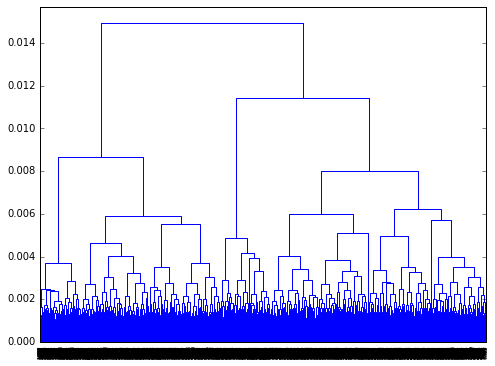

[1 2 3 4 5]
1.1 =  234
1.2 =  796
1.3 =  290
1.4 =  557
1.5 =  675


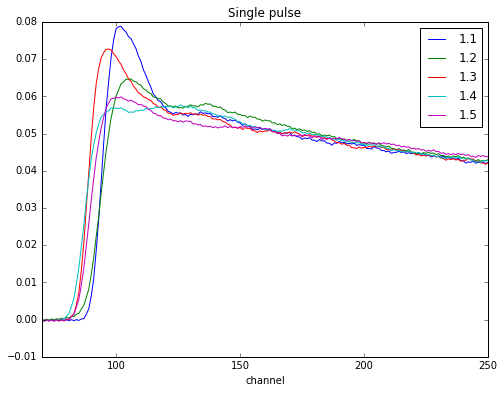

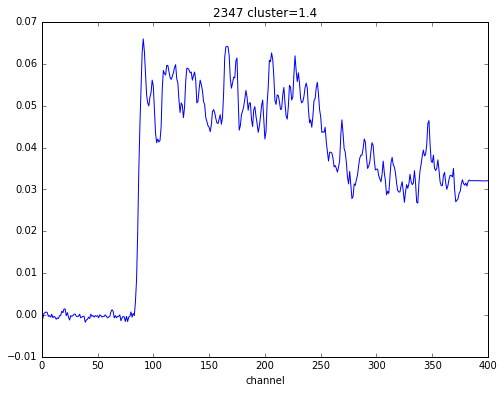

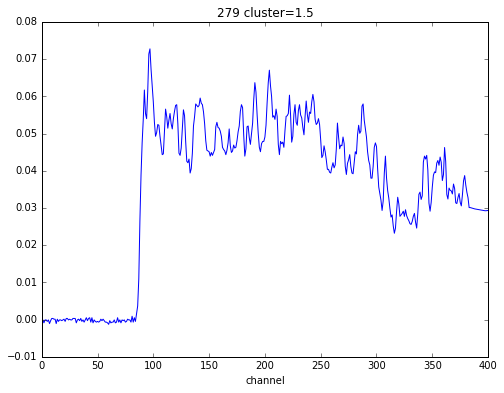

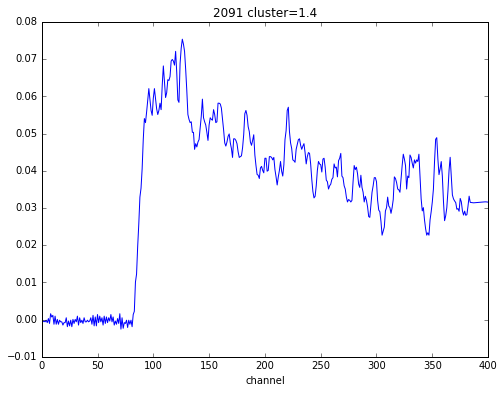

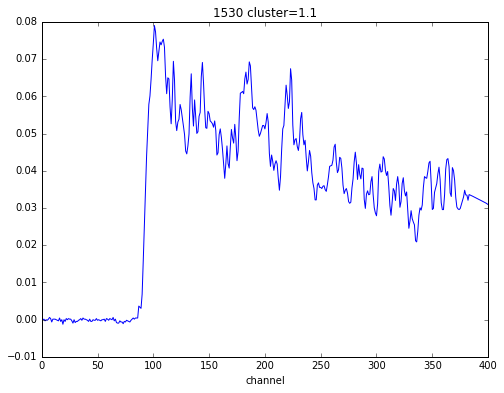

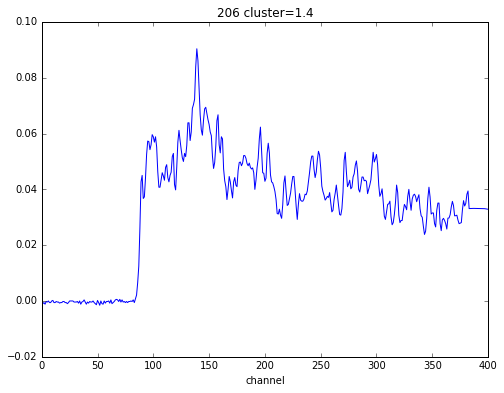

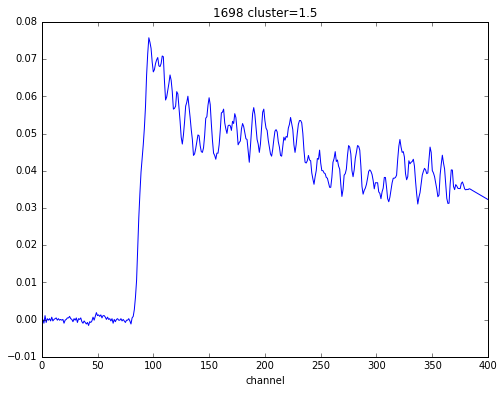

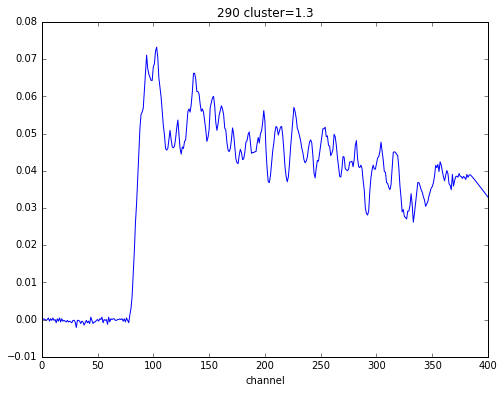

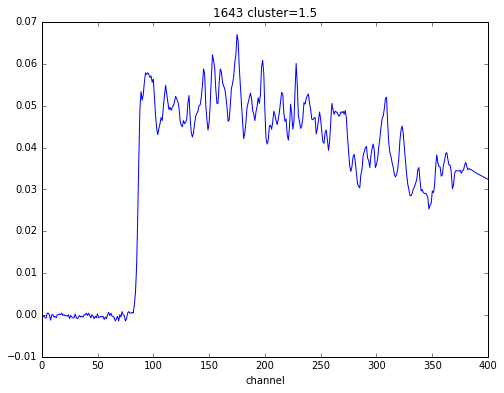

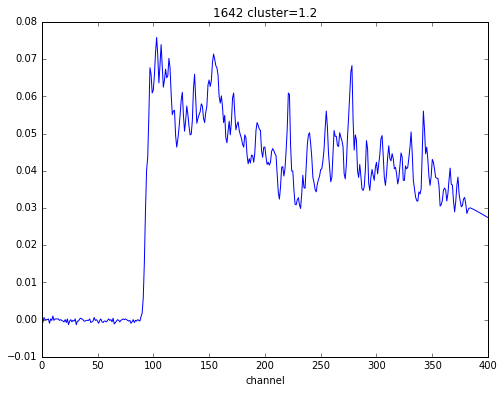

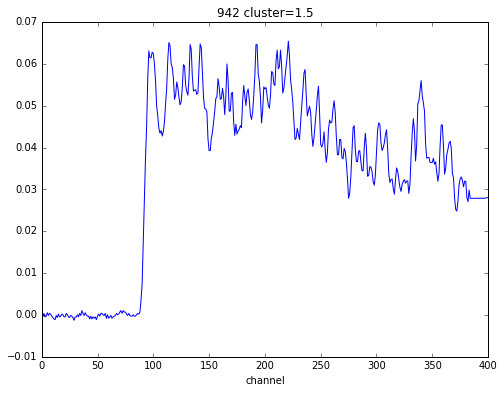

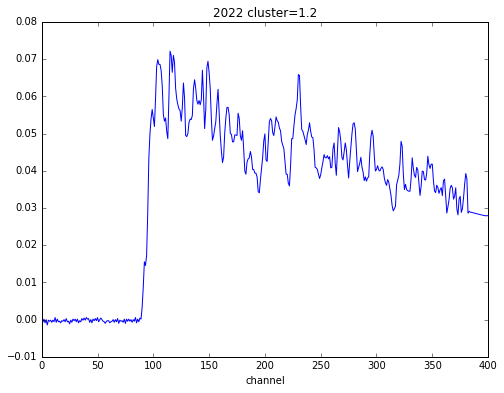

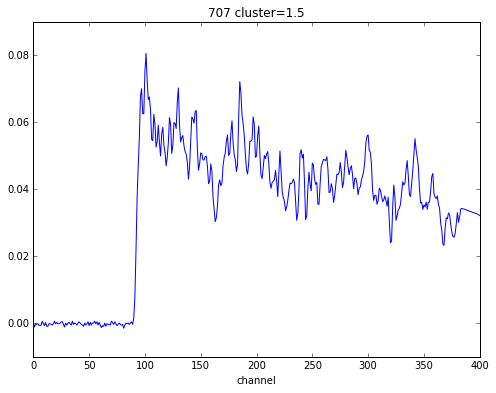

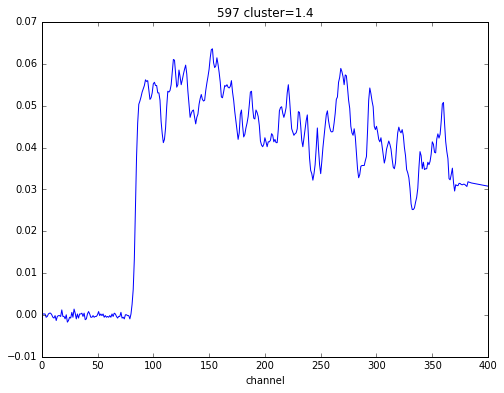

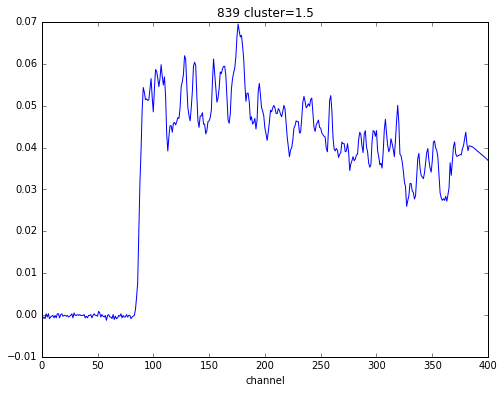

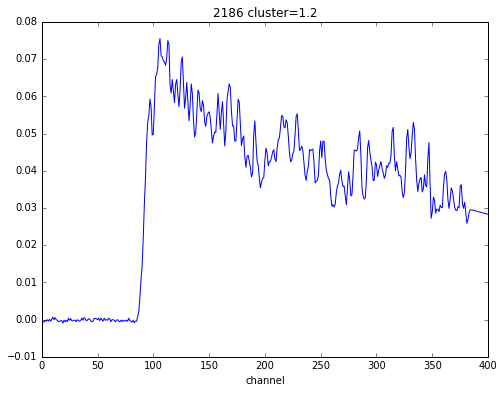

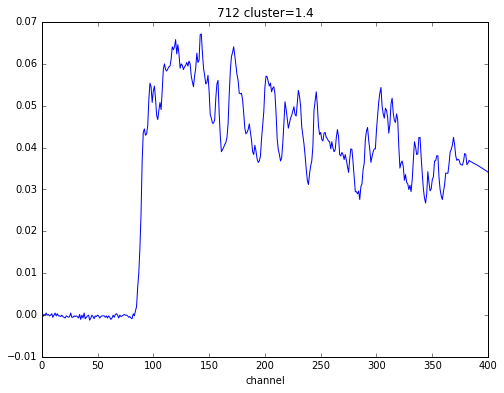

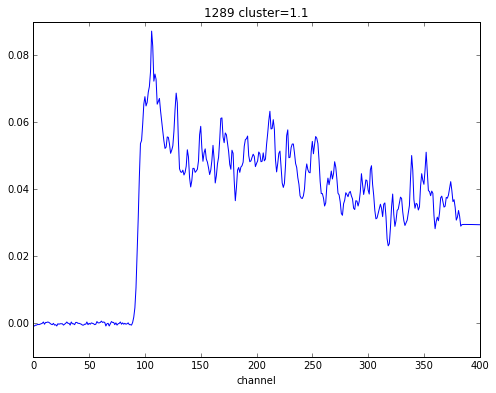

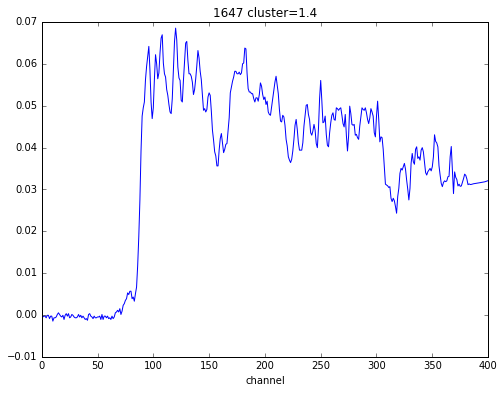

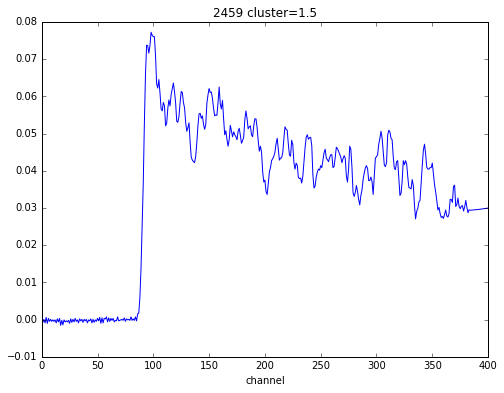

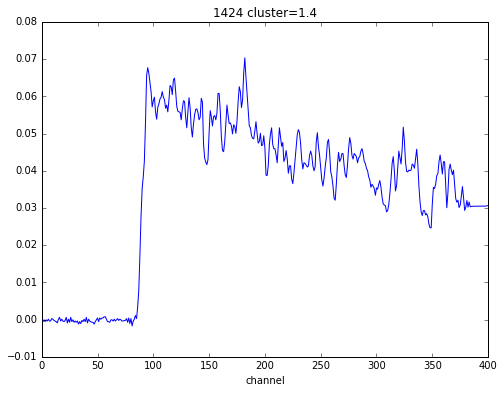

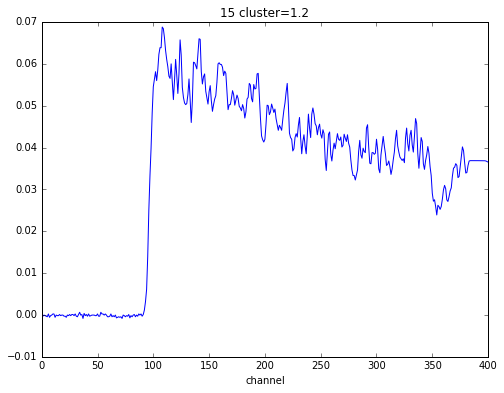

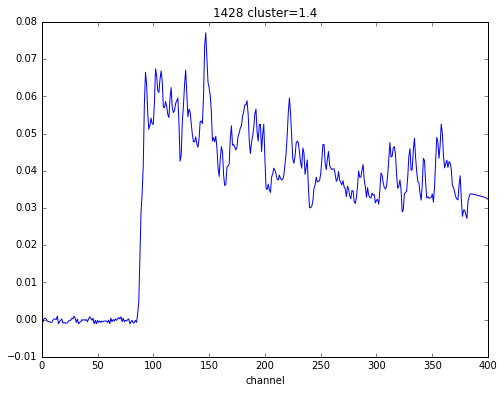

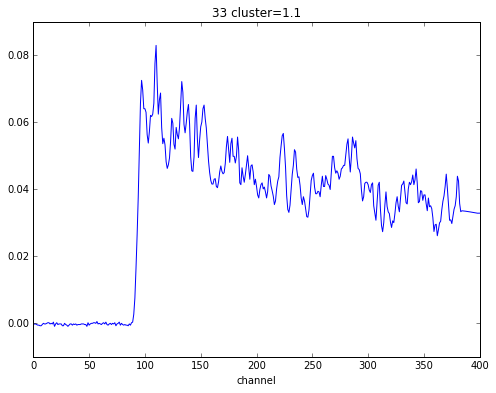

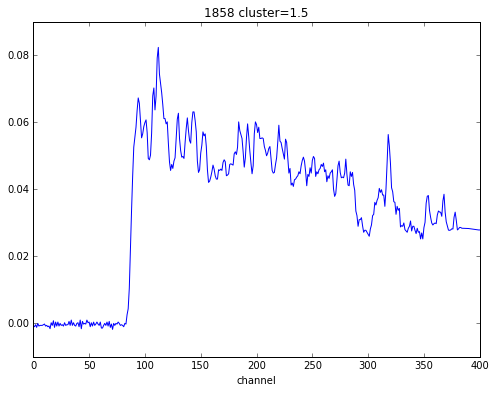

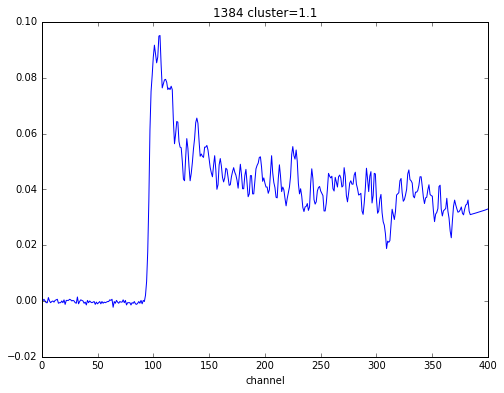

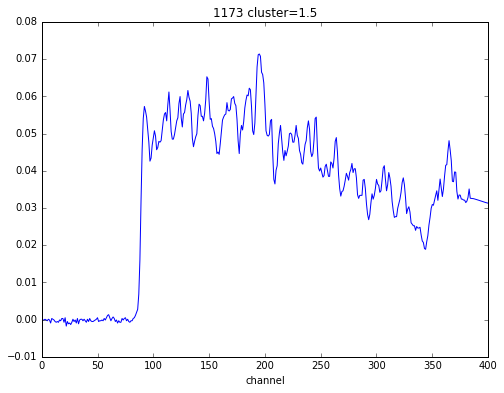

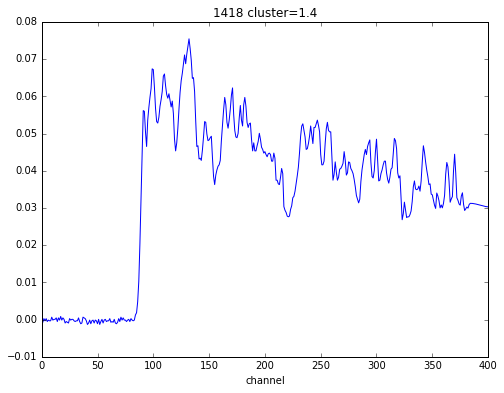

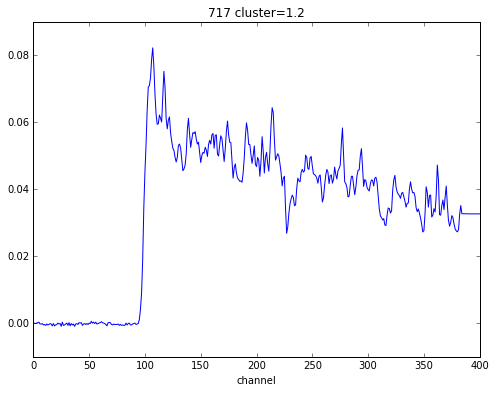

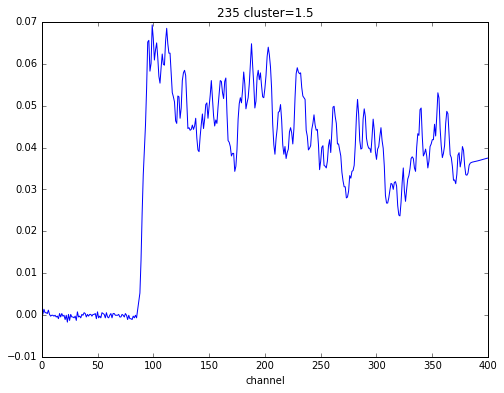

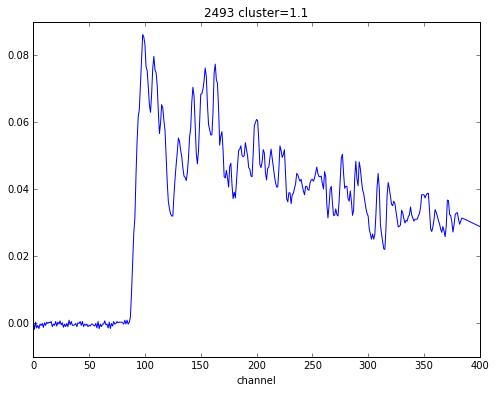

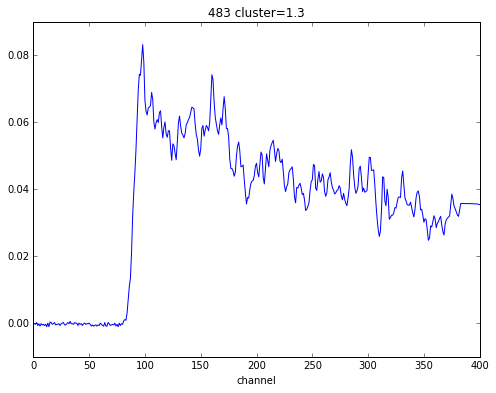

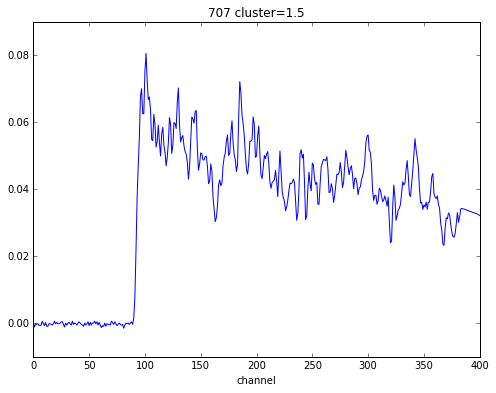

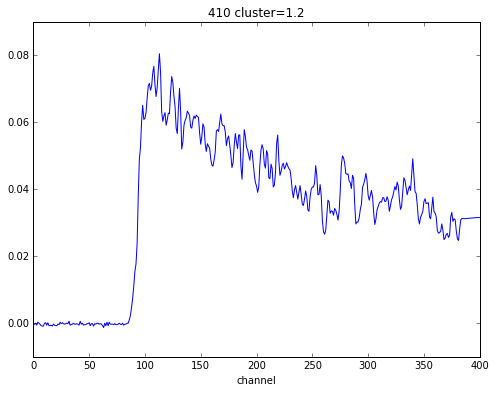

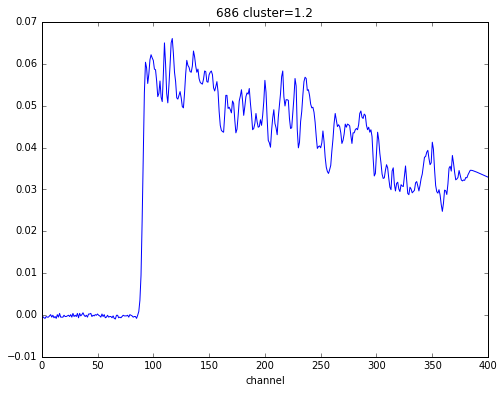

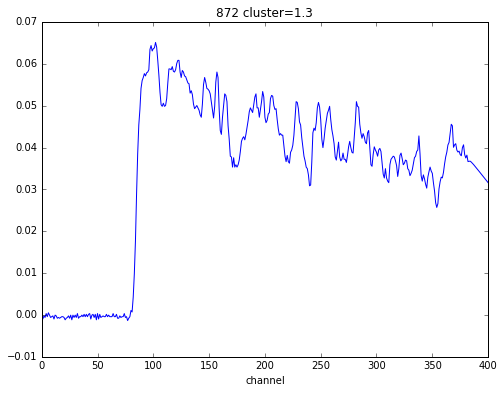

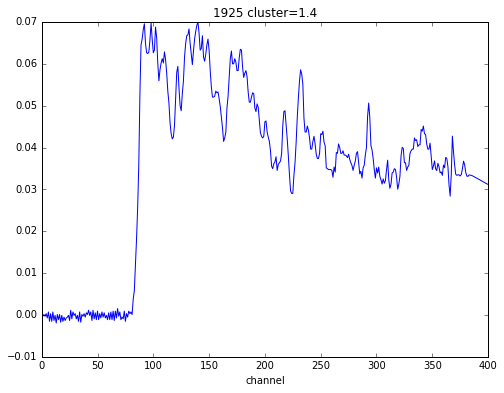

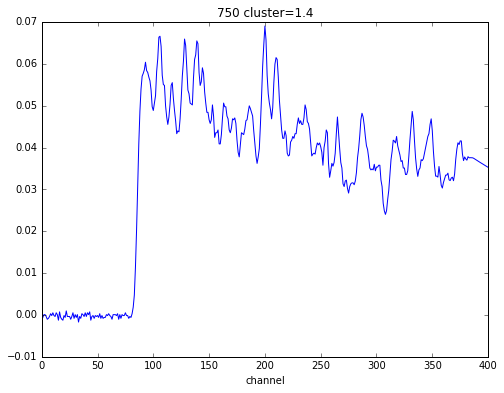

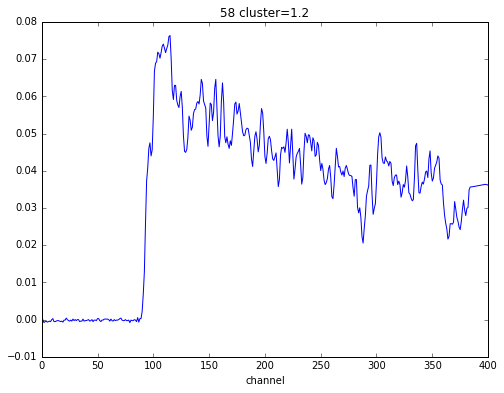

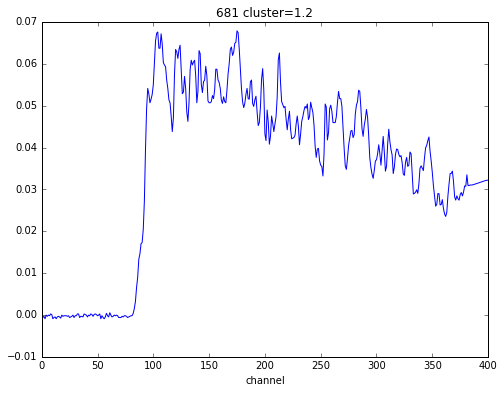

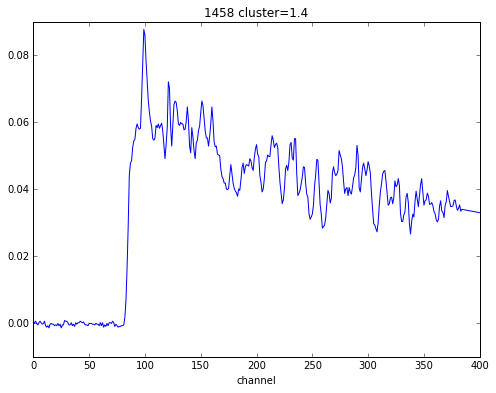

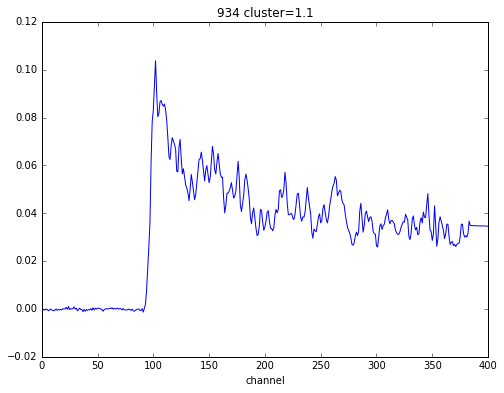

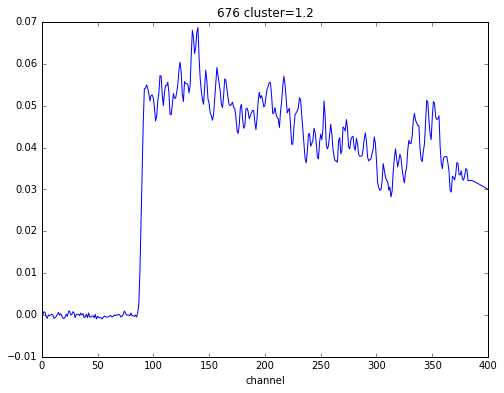

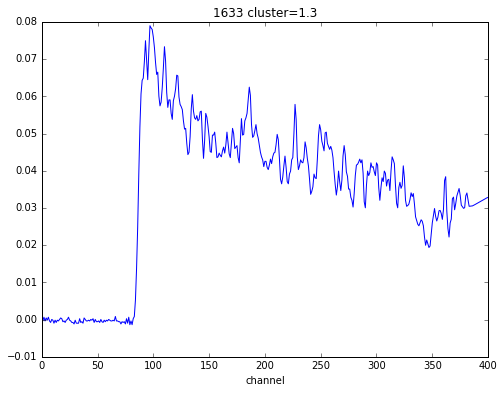

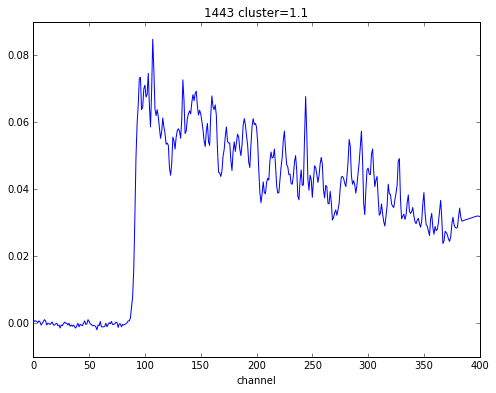

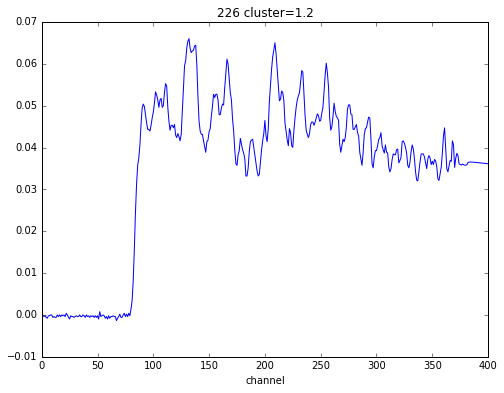

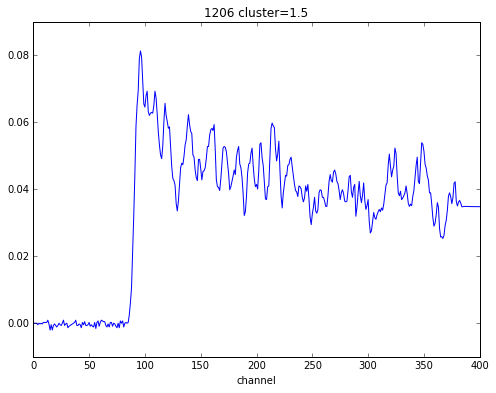

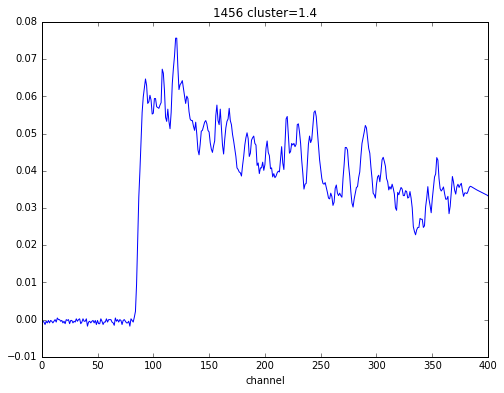

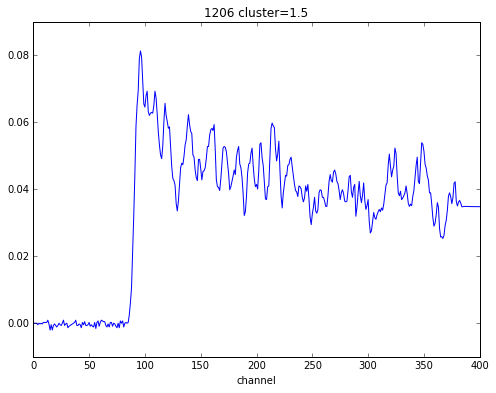

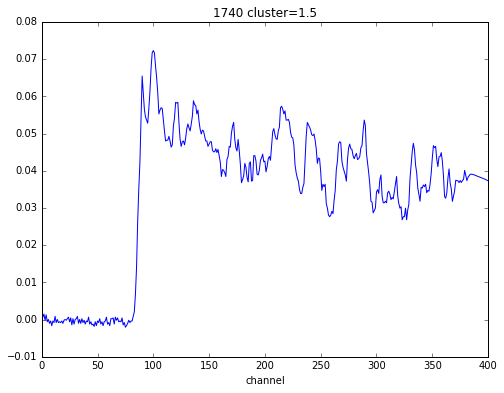

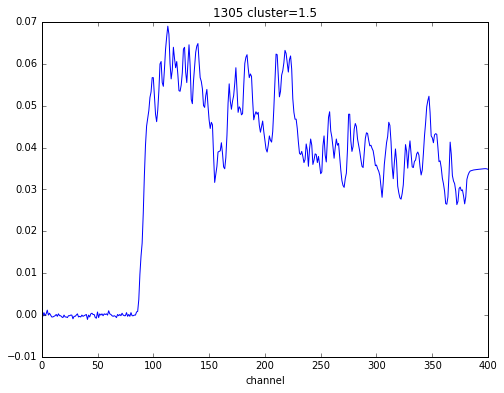

CPU times: user 44 s, sys: 4.04 s, total: 48.1 s
Wall time: 46.3 s


In [8]:
%%time

selector = np.empty(2552)

try:
    for batch_number, waveform in enumerate(data_loader):
        average = []
        average2 = []
        average3 = []
        average4 = []
        average5 = []

        batch_size = waveform.size()[0]
#         print(batch_size)
        waveform_in = to_var(waveform.view(batch_size,1,4096)) 
        features = GEN.encoder(waveform_in)
        
        green = np.reshape(features[0].detach().numpy(),(batch_size,-1))
        Z = linkage(green, method="ward")

        fig = plt.figure(figsize=(8, 6))
        dn = dendrogram(Z, color_threshold=0)
        plt.show()
        
        clusters = fcluster(Z, 0.007, criterion='distance')
        print(np.unique(clusters))
        selector = clusters
        
        for i, waveform_out in enumerate(features[0]):
            
            blue = waveform_in[i].detach().numpy()
#             if clusters[i]==4:
#                 plt.figure()
#                 plt.plot(waveform[i])
#                 plt.show()

            if clusters[i]==1:
                average.append(blue[0])
                
            if clusters[i]==2:
                average2.append(blue[0])
            
            if clusters[i]==3:
                average3.append(blue[0])
                
            if clusters[i]==4:
                average4.append(blue[0])
                
            if clusters[i]==5:
                average5.append(blue[0])
                
        dang = np.mean(average, axis=0)
        dang2 = np.mean(average2, axis=0)
        dang3 = np.mean(average3, axis=0)
        dang4 = np.mean(average4, axis=0)
        dang5 = np.mean(average5, axis=0)
        
        print("1.1 = ", np.count_nonzero(clusters==1))
        print("1.2 = ", np.count_nonzero(clusters==2))
        print("1.3 = ", np.count_nonzero(clusters==3))
        print("1.4 = ", np.count_nonzero(clusters==4))
        print("1.5 = ", np.count_nonzero(clusters==5))
        
        plt.figure(figsize=(8,6))
        plt.plot(dang,label="1.1")
        plt.plot(dang2,label="1.2")
        plt.plot(dang3,label="1.3")
        plt.plot(dang4,label="1.4")
        plt.plot(dang5,label="1.5")
        plt.xlim(70,250)
        plt.xlabel("channel")
        plt.legend()
        plt.title("Single pulse")
        plt.show()
        
        for i in range(50):
            rd = np.random.randint(2552)
            plt.figure(figsize=(8,6))
            plt.plot(waveform[rd].detach().numpy())
#             plt.plot(average3[rd], label="1")
#             plt.plot(average4[0], label="2")
#             plt.plot(average5[0], label="3")
    #         plt.plot(dang4,label="4")
            plt.xlim(0,400)
            plt.xlabel("channel")
#             plt.legend()
            plt.title("{} cluster=1.{}".format(rd,clusters[rd]))
            plt.show()
                    
#         Features[batch_number*1000:(batch_number+1)*1000] = feat[0]
        
        
#         print(Features.size())
    # db = DBSCAN(eps=0.3, min_samples=20).fit(DATA.detach().numpy())
    # print(db.core_sample_indices_)
    # print(db.labels_)
        

except KeyboardInterrupt:
    print('Training ended early.')

# Waveform

In [ ]:
try:
    for batch_number, waveform in enumerate(data_loader):

        if batch_number == 1:
            break
        batch_size = waveform.size()[0]
        green = np.reshape(waveform.detach().numpy(),(batch_size,-1))
        print(green.shape)
        Z = linkage(green, method="ward")
        print(Z.shape)
#         print(Z)
        fig = plt.figure(figsize=(12, 8))
        dn = dendrogram(Z)
        plt.show()
        
        clusters = fcluster(Z, 5, criterion='distance')
        print(clusters.shape)
        print(clusters)
        print(np.unique(clusters))
        
        for i, waveform_i in enumerate(waveform):
#             if clusters[i]==3:
#                 plt.figure()
#                 plt.plot(waveform[i])
#                 plt.show()
#             if clusters[i]==1:
#                 un1.append(green[i])
                
#             if clusters[i]==2:
#                 un2.append(green[i])
                
except KeyboardInterrupt:
    print('Training ended early.')

In [ ]:
print(selector)
np.save("selector_psd",selector)

# Plot spectrum

In [11]:
tree = uproot.open("../Run9psd15_3000.root")["tree"]
energy = tree.array("Energy")
print(tree)
del tree
energy = energy[:,1]

refine = np.load("selector_psd.npy")
energy = energy[refine==1]

energy1 = energy[selector==1]
energy2 = energy[selector==2]
energy3 = energy[selector==3]
energy4 = energy[selector==4]
energy5 = energy[selector==5]


<TTree b'tree' at 0x00011c340588>


2552


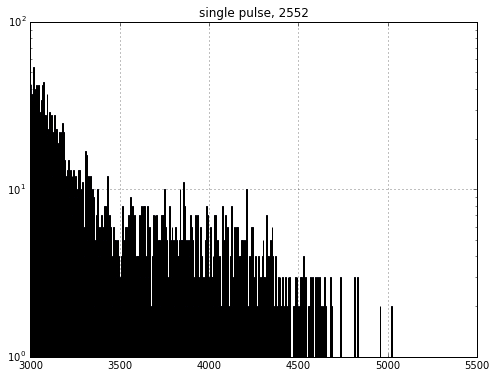

In [15]:
title = len(selector)
print(title)
plt.figure(figsize=(8, 6))
plt.hist(energy,bins=np.arange(3000,5500,5))
plt.yscale("log")
plt.title("single pulse, {}".format(title))
plt.grid(True)
plt.show()

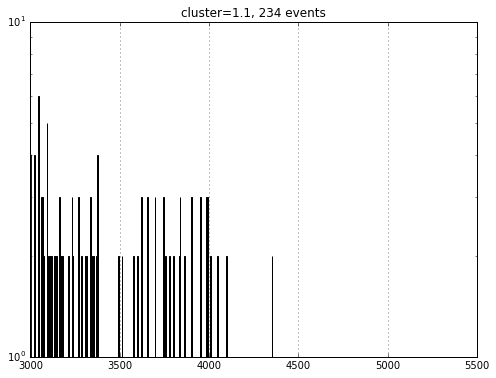

BG rate without Tl208 cut
no. of events 4000 keV < Energy[1] < 4500 keV = 33


In [38]:
title = np.count_nonzero(selector==1)
plt.figure(figsize=(8, 6))
plt.hist(energy1,bins=np.arange(3000,5500,5))
plt.yscale("log")
plt.title("cluster=1.1, {} events".format(title))
plt.grid(True)
plt.show()

ROI1 = np.count_nonzero(energy1<4000)
ROI2 = np.count_nonzero(energy1>4500)
ROI = title-ROI1-ROI2
print("BG rate without Tl208 cut")
print("no. of events 4000 keV < Energy[1] < 4500 keV = {}".format(ROI))

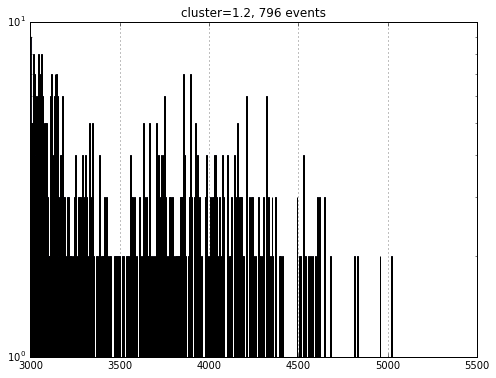

BG rate without Tl208 cut
no. of events 4000 keV < Energy[1] < 4500 keV = 179


In [47]:
title = np.count_nonzero(selector==2)
plt.figure(figsize=(8, 6))
plt.hist(energy2,bins=np.arange(3000,5500,5), edgecolor=None)
plt.yscale("log")
plt.title("cluster=1.2, {} events".format(title))
plt.grid(True)
plt.show()

ROI1 = np.count_nonzero(energy2<4000)
ROI2 = np.count_nonzero(energy2>4500)
ROI = title-ROI1-ROI2
print("BG rate without Tl208 cut")
print("no. of events 4000 keV < Energy[1] < 4500 keV = {}".format(ROI))

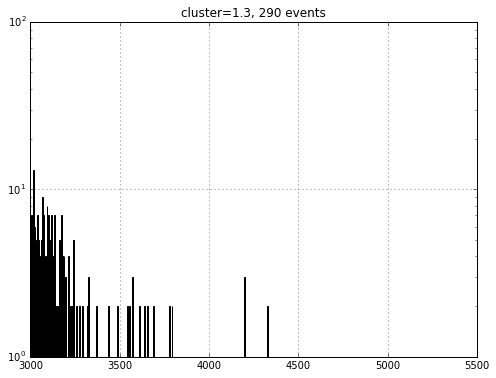

BG rate without Tl208 cut
no. of events 4000 keV < Energy[1] < 4500 keV = 18


In [40]:
title = np.count_nonzero(selector==3)
plt.figure(figsize=(8, 6))
plt.hist(energy3,bins=np.arange(3000,5500,5))
# plt.xlim(4000,4500)
plt.title("cluster=1.3, {} events".format(title))
plt.grid(True)
plt.yscale("log")
plt.show()

ROI1 = np.count_nonzero(energy3<4000)
ROI2 = np.count_nonzero(energy3>4500)
ROI = title-ROI1-ROI2
print("BG rate without Tl208 cut")
print("no. of events 4000 keV < Energy[1] < 4500 keV = {}".format(ROI))

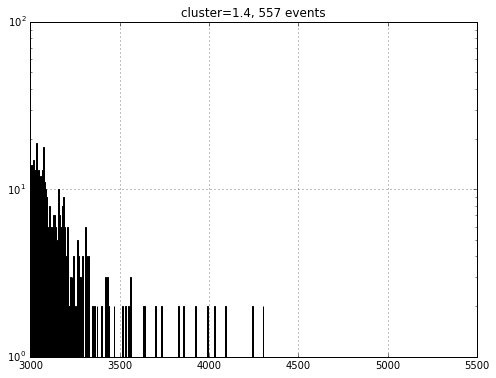

BG rate without Tl208 cut
no. of events 4000 keV < Energy[1] < 4500 keV = 29


In [41]:
title = np.count_nonzero(selector==4)
plt.figure(figsize=(8, 6))
plt.hist(energy4,bins=np.arange(3000,5500,5))
plt.yscale("log")
plt.title("cluster=1.4, {} events".format(title))
plt.grid(True)
plt.show()

ROI1 = np.count_nonzero(energy4<4000)
ROI2 = np.count_nonzero(energy4>4500)
ROI = title-ROI1-ROI2
print("BG rate without Tl208 cut")
print("no. of events 4000 keV < Energy[1] < 4500 keV = {}".format(ROI))

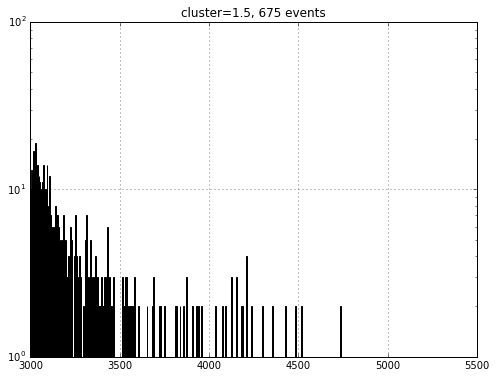

BG rate without Tl208 cut
no. of events 4000 keV < Energy[1] < 4500 keV = 65


In [42]:
title = np.count_nonzero(selector==5)
plt.figure(figsize=(8, 6))
plt.hist(energy5,bins=np.arange(3000,5500,5))
plt.yscale("log")
plt.title("cluster=1.5, {} events".format(title))
plt.grid(True)
plt.show()

ROI1 = np.count_nonzero(energy5<4000)
ROI2 = np.count_nonzero(energy5>4500)
ROI = title-ROI1-ROI2
print("BG rate without Tl208 cut")
print("no. of events 4000 keV < Energy[1] < 4500 keV = {}".format(ROI))

# parameter distribution 

In [11]:
tree = uproot.open("../Run9psd15_3000.root")["tree"]
pedestal = tree.array("Pedestal")
psdpara = tree.array("PSDPara")
crystaln = tree.array("CrystalN")
ratior = tree.array("RatioR")
print(tree)
del tree
pedestal = pedestal[:,0]
psdpara = psdpara[:,1]
crystaln = crystaln[:,0]
ratior = ratior[:,1]

refine = np.load("selector_psd.npy")
pedestal = pedestal[refine==1]
psdpara = psdpara[refine==1]
crystaln = crystaln[refine==1]
ratior = ratior[refine==1]

pedestal1 = pedestal[selector==1]
pedestal2 = pedestal[selector==2]
pedestal3 = pedestal[selector==3]
pedestal4 = pedestal[selector==4]
pedestal5 = pedestal[selector==5]
    
psdpara1 = psdpara[selector==1]
psdpara2 = psdpara[selector==2]
psdpara3 = psdpara[selector==3]
psdpara4 = psdpara[selector==4]
psdpara5 = psdpara[selector==5]

crystaln1 = crystaln[selector==1]
crystaln2 = crystaln[selector==2]
crystaln3 = crystaln[selector==3]
crystaln4 = crystaln[selector==4]
crystaln5 = crystaln[selector==5]

ratior1 = ratior[selector==1]
ratior2 = ratior[selector==2]
ratior3 = ratior[selector==3]
ratior4 = ratior[selector==4]
ratior5 = ratior[selector==5]


<TTree b'tree' at 0x00011a5610b8>


In [12]:
print(pedestal)
print(psdpara)
print(crystaln)
print(ratior)

[15189.083 15187.942 15187.299 ... 15185.607 15187.628 15184.847]
[0.9900514 1.499529  1.3423342 ... 1.1536947 0.8583697 1.0678365]
[13 23 42 ... 74 89 22]
[0.36221352 0.4308205  0.4654087  ... 0.41749558 0.34954575 0.44713688]


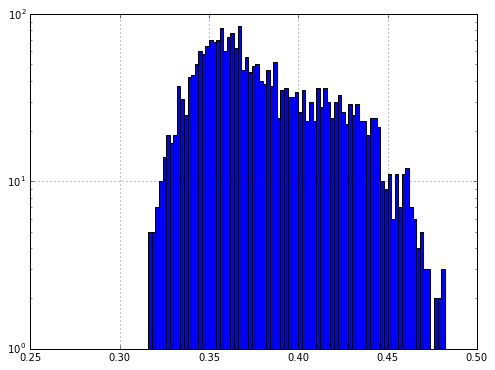

In [18]:
plt.figure(figsize=(8, 6))
plt.hist(ratior,bins=np.arange(0.3,0.5,0.002))
plt.grid(True)
plt.yscale("log")
plt.show()

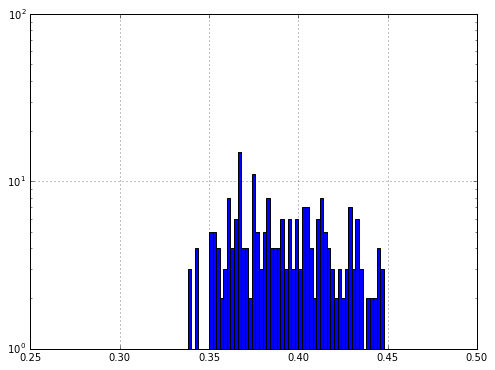

In [19]:
plt.figure(figsize=(8, 6))
plt.hist(ratior1,bins=np.arange(0.3,0.5,0.002))
plt.grid(True)
plt.yscale("log")
plt.show()

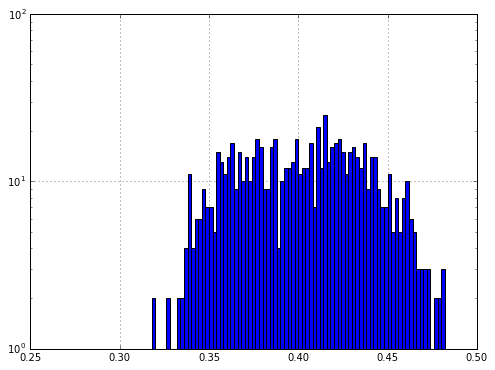

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(ratior2,bins=np.arange(0.3,0.5,0.002))
plt.grid(True)
plt.yscale("log")
plt.show()

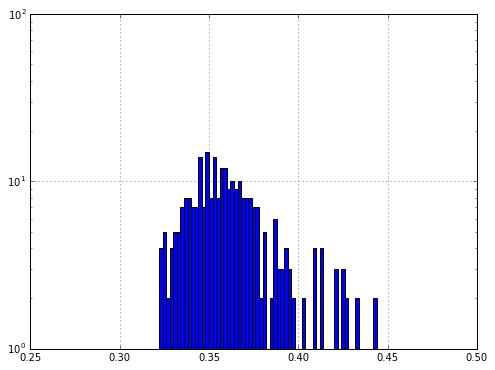

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(ratior3,bins=np.arange(0.3,0.5,0.002))
plt.grid(True)
plt.yscale("log")
plt.show()

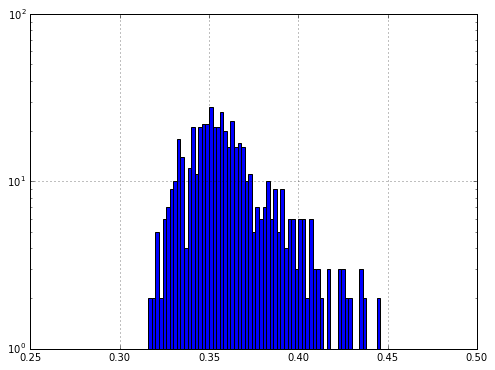

In [22]:
plt.figure(figsize=(8, 6))
plt.hist(ratior4,bins=np.arange(0.3,0.5,0.002))
plt.grid(True)
plt.yscale("log")
plt.show()

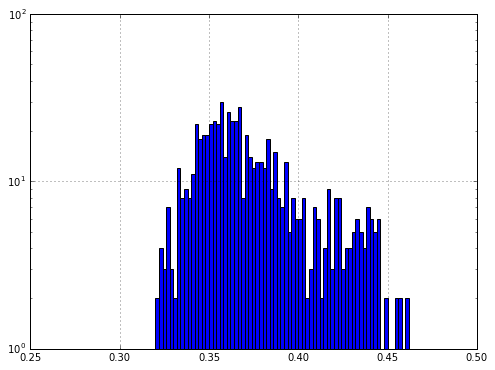

In [23]:
plt.figure(figsize=(8, 6))
plt.hist(ratior5,bins=np.arange(0.3,0.5,0.002))
plt.grid(True)
plt.yscale("log")
plt.show()

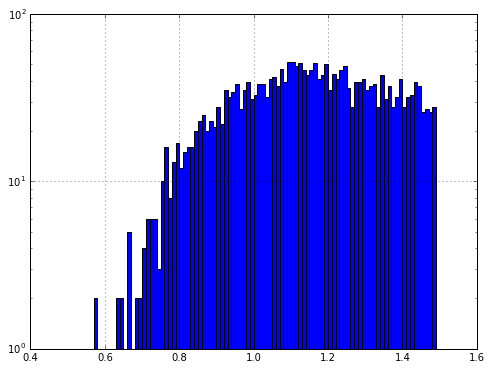

In [24]:
plt.figure(figsize=(8, 6))
plt.hist(psdpara,bins=np.arange(0.5,1.5,0.01))
plt.grid(True)
plt.yscale("log")
plt.show()

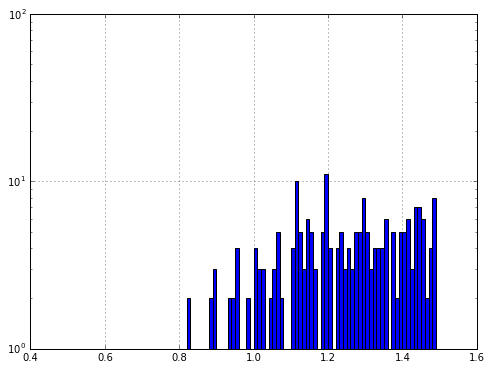

In [47]:
plt.figure(figsize=(8, 6))
plt.hist(psdpara1,bins=np.arange(0.5,1.5,0.01))
plt.grid(True)
plt.yscale("log")
plt.show()

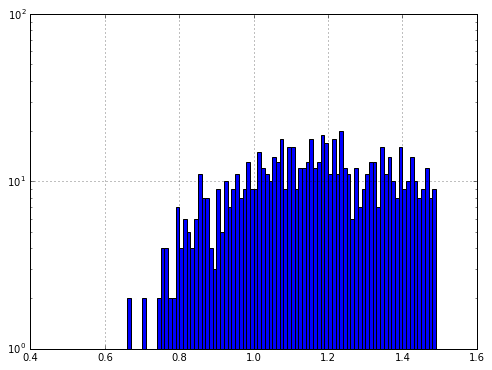

In [48]:
plt.figure(figsize=(8, 6))
plt.hist(psdpara2,bins=np.arange(0.5,1.5,0.01))
plt.grid(True)
plt.yscale("log")
plt.show()

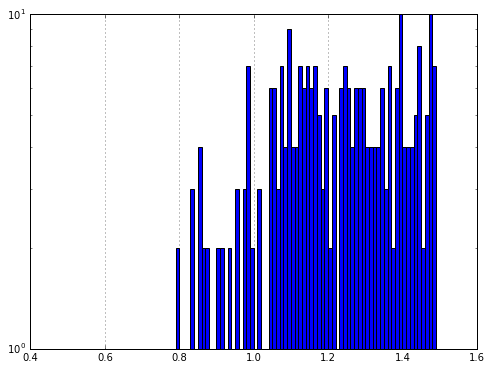

In [49]:
plt.figure(figsize=(8, 6))
plt.hist(psdpara3,bins=np.arange(0.5,1.5,0.01))
plt.grid(True)
plt.yscale("log")
plt.show()

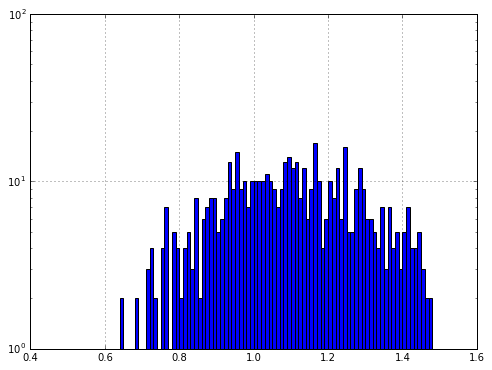

In [50]:
plt.figure(figsize=(8, 6))
plt.hist(psdpara4,bins=np.arange(0.5,1.5,0.01))
plt.grid(True)
plt.yscale("log")
plt.show()

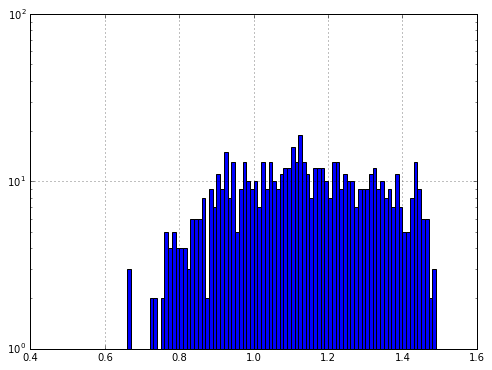

In [51]:
plt.figure(figsize=(8, 6))
plt.hist(psdpara5,bins=np.arange(0.5,1.5,0.01))
plt.grid(True)
plt.yscale("log")
plt.show()

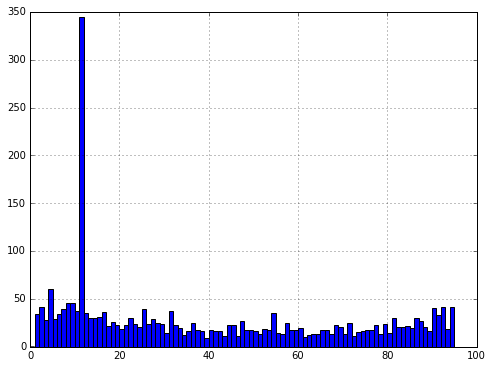

In [31]:
plt.figure(figsize=(8, 6))
plt.hist(crystaln,bins=np.arange(0,96,1))
plt.grid(True)
# plt.yscale("log")
plt.show()

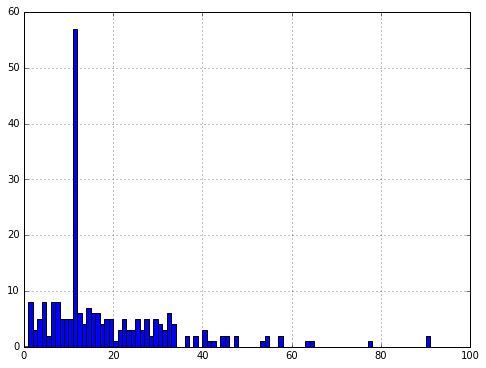

In [32]:
plt.figure(figsize=(8, 6))
plt.hist(crystaln1,bins=np.arange(0,96,1))
plt.grid(True)
# plt.yscale("log")
plt.show()

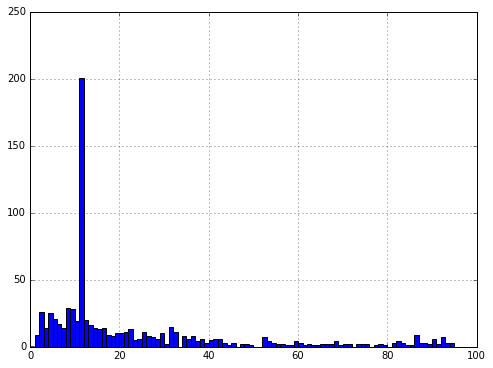

In [33]:
plt.figure(figsize=(8, 6))
plt.hist(crystaln2,bins=np.arange(0,96,1))
plt.grid(True)
# plt.yscale("log")
plt.show()

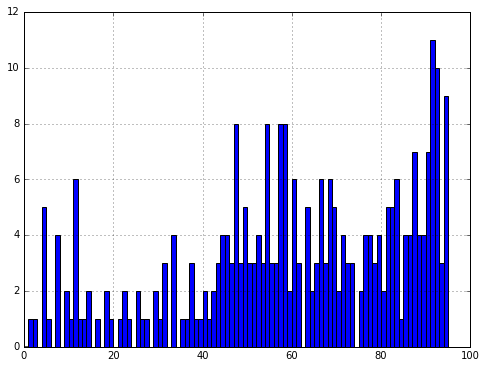

In [34]:
plt.figure(figsize=(8, 6))
plt.hist(crystaln3,bins=np.arange(0,96,1))
plt.grid(True)
# plt.yscale("log")
plt.show()

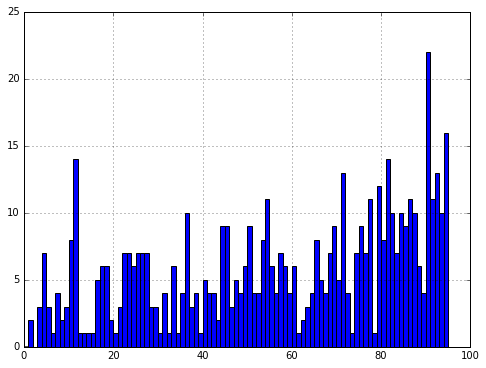

In [35]:
plt.figure(figsize=(8, 6))
plt.hist(crystaln4,bins=np.arange(0,96,1))
plt.grid(True)
# plt.yscale("log")
plt.show()

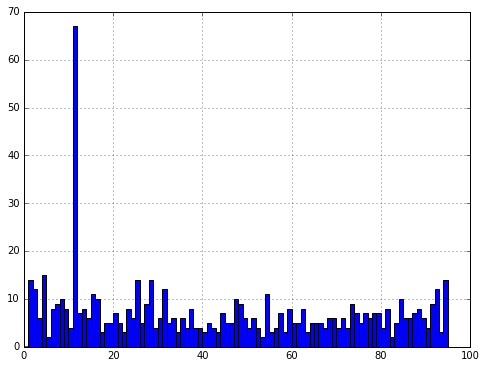

In [36]:
plt.figure(figsize=(8, 6))
plt.hist(crystaln5,bins=np.arange(0,96,1))
plt.grid(True)
# plt.yscale("log")
plt.show()

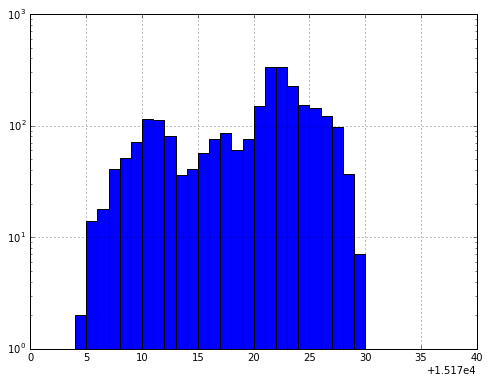

In [30]:
# title = np.count_nonzero(selector==1)
plt.figure(figsize=(8, 6))
plt.hist(pedestal,bins=np.arange(15170,15210,1))
# plt.xlim(4000,4500)
# plt.title("cluster=1.3, {} events".format(title))
plt.grid(True)
plt.yscale("log")
plt.show()

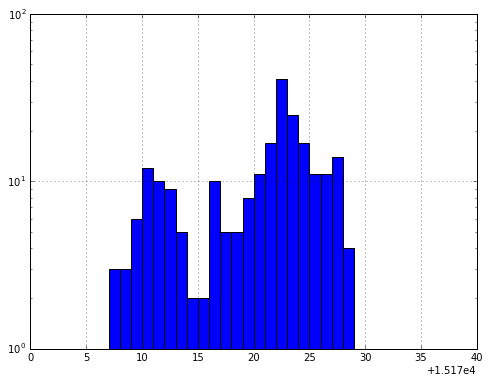

In [19]:
plt.figure(figsize=(8, 6))
plt.hist(pedestal1,bins=np.arange(15170,15210,1))
plt.grid(True)
plt.yscale("log")
plt.show()

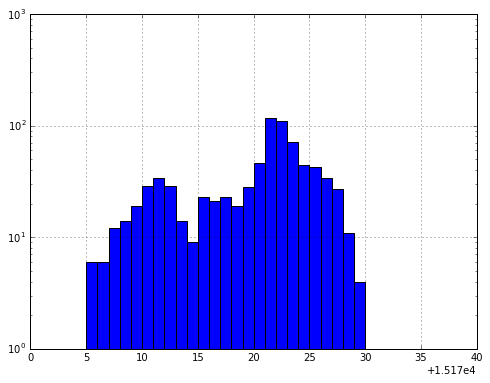

In [20]:
plt.figure(figsize=(8, 6))
plt.hist(pedestal2,bins=np.arange(15170,15210,1))
plt.grid(True)
plt.yscale("log")
plt.show()

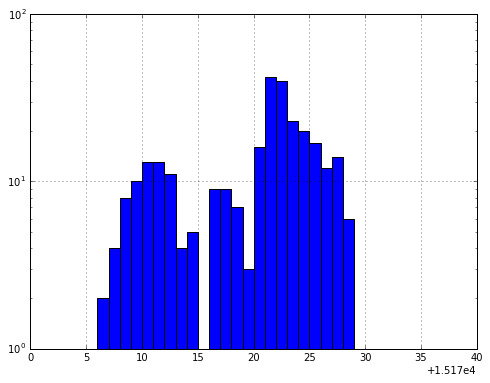

In [21]:
plt.figure(figsize=(8, 6))
plt.hist(pedestal3,bins=np.arange(15170,15210,1))
plt.grid(True)
plt.yscale("log")
plt.show()

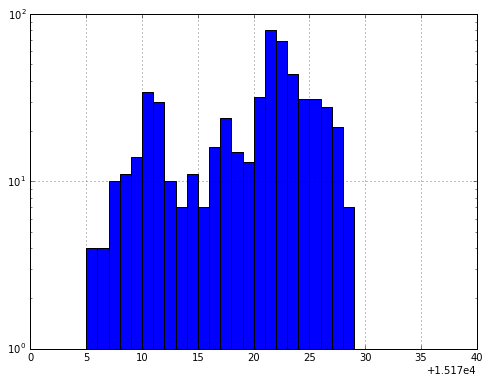

In [22]:
plt.figure(figsize=(8, 6))
plt.hist(pedestal4,bins=np.arange(15170,15210,1))
plt.grid(True)
plt.yscale("log")
plt.show()

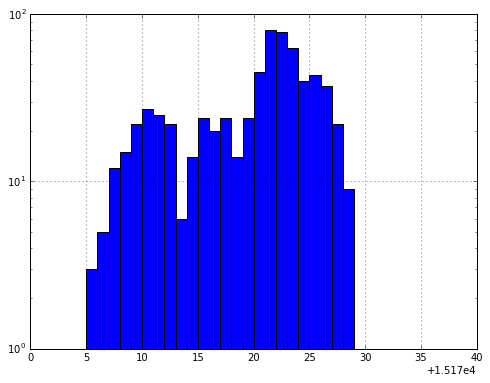

In [23]:
plt.figure(figsize=(8, 6))
plt.hist(pedestal5,bins=np.arange(15170,15210,1))
plt.grid(True)
plt.yscale("log")
plt.show()